In [1]:
from lenskit.metrics import dataGenerator
from lenskit import batch, topn, util, topnFair
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, user_knn as knn
from lenskit import topn, topnFair

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

In [3]:
#ratings = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/ratings.1.csv', sep=',',
#                      names=['user', 'item', 'rating', 'timestamp'], header=0)

#items = pd.read_csv('/Users/denisehansen/Desktop/ITU/Thesis/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
#                      names=['movieId','title','genres'], header=0)

ratings = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/ratings.csv', sep=',',
                      names=['user', 'item', 'rating', 'timestamp'], header=0)

items = pd.read_csv('/Users/josse/Git-kode projects/Speciale/Fair-Recommendations/ml-latest-small/movies.csv', sep=',',
                      names=['item','title','genres'], header=0)

#C:\Users\josse\Git-kode projects\Speciale\Fair-Recommendations\ml-latest-small\ratings.csv

In [4]:
#items

In [5]:
items_dummy = pd.concat([items, items['genres'].str.get_dummies(sep='|')], axis=1)
items_dummy.head()

,item,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
algo_ii = knn.UserUser(20)
algo_als = als.BiasedMF(50)

In [7]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [8]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 1, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))
   
    

test _reccomend
test _reccomend


In [9]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs_joined = all_recs.join(items_dummy.set_index('item'), on='item')
all_recs_joined.head()

,item,score,user,rank,Algorithm,title,genres,(no genres listed),Action,Adventure,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,91104,5.854779,1,1,ItemItem,"Twilight Saga: Breaking Dawn - Part 1, The (2011)",Adventure|Drama|Fantasy|Romance,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,73290,5.175616,1,2,ItemItem,Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's ...,Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,106441,5.175616,1,3,ItemItem,"Book Thief, The (2013)",Children|Drama|War,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,97957,4.907405,1,4,ItemItem,Excision (2012),Crime|Drama|Horror|Thriller,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,26974,4.907405,1,5,ItemItem,Gummo (1997),Drama,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test_data = pd.concat(test_data, ignore_index=True)
test_data.head()

,user,item,rating
0,1,1953,4.0
1,1,1287,2.0
2,1,1343,2.0
3,1,31,2.5
4,2,500,4.0


In [11]:
_protected_group2 = all_recs_joined.loc[all_recs_joined['Action'] == 1]
_protected_group2.head()
_protected_group2['item'].values

array([ 4802,  5301, 98961, ...,  3578,  1249, 81834], dtype=int64)

In [12]:
# user , algorithms = iput to group_cols --> de koloner der skal  groupes på 
res= list(all_recs_joined.iloc[:,8:])
print(res)

rla = topnFair.FairRecListAnalysis(['user', "Algorithm"])
rla.add_metric("rND")
rla.add_metric("rKL")
rla.add_metric("rRD")
rla.add_metric("div")
results = rla.compute(all_recs_joined, test_data, res)
results.head()

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
ti_cols:  ['user', 'item']
res.index:  MultiIndex(levels=[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 16

calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5485136940396927
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.6350147648671912
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 20 , measure rND
normalizer value to return :  0.6258898399990829
calculating normalizer with userN= 100 , proN 20 , measure rKL
normalizer value to return :  0.5894169474153228
calculating normalizer with userN= 100 , proN 20 , measure rRD
normalizer value to return :  0.41182819993092445
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4827961072296928
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878855
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer

calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND
normalizer value to return :  0.5929350804974083
calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.6415396436620886
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer value to return :  0.34017843885226096
measure = div
calculating normalizer with userN= 100 , proN 16 , measure rND
normalizer value to return :  0.57216971140014
calculating normalizer with userN= 100 , proN 16 , measure rKL
normalizer value to return :  0.779969737390271
calculating normalizer with userN= 100 , proN 16 , measure rRD
normalizer value

calculating normalizer with userN= 100 , proN 14 , measure rKL
normalizer value to return :  0.7564029791992943
calculating normalizer with userN= 100 , proN 14 , measure rRD
normalizer value to return :  0.27352749831396933
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.4591400898692455
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.45054175202400104
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46492138639560326
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.38139239443712913
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 14 , measure

calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer value to return :  0.1499255428581417
measure = div
calculating normalizer with userN= 100 , proN 18 , measure rND
normalizer value to return :  0.6050285048051399
calculating normalizer with userN= 100 , proN 18 , measure rKL
normalizer value to return :  0.7921492665413388
calculating normalizer with userN= 100 , proN 18 , measure rRD
normalizer value to return :  0.3634791741623954
measure = div
calculating normalizer with userN= 100 , proN 8 , measure rND
normalizer value to return :  0.37424962772702575
calculating normalizer with userN= 100 , proN 8 , measure rKL
normalizer value to return :  0.8475530556349968
calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer value to return :  0.1499255428581417
measure = div
calculating normalizer with userN= 100 , proN 7 , measure rND
normalizer value to return :  0.3274684242611475
calculating normalizer with userN= 100 , proN 7 , measure rKL
norm

calculating normalizer with userN= 100 , proN 19 , measure rND
normalizer value to return :  0.6108162271192383
calculating normalizer with userN= 100 , proN 19 , measure rKL
normalizer value to return :  0.8531104194659077
calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5156549006346927
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.43614474608481507
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer v

calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.5723659400421306
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5456230457765139
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.6350147648671911
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND
normalizer value to return :  0.5035614763269611
calculating normalizer with userN= 100 , proN 12 , measure rKL
normalizer value to return :  0.454119976120681
calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rN

calculating normalizer with userN= 100 , proN 16 , measure rND
normalizer value to return :  0.57216971140014
calculating normalizer with userN= 100 , proN 16 , measure rKL
normalizer value to return :  0.6820862863571667
calculating normalizer with userN= 100 , proN 16 , measure rRD
normalizer value to return :  0.31743248295427245
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46492138639560326
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.3649178672815147
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.5306389732056032
calculating normalizer with userN= 100 , proN 14 , measure rKL
normalizer value to return :  0.5919124808055652
calculating normalizer with userN= 100 , proN 14 , measure rRD
normalizer va

calculating normalizer with userN= 100 , proN 8 , measure rND
normalizer value to return :  0.37424962772702575
calculating normalizer with userN= 100 , proN 8 , measure rKL
normalizer value to return :  0.8475530556349968
calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer value to return :  0.1499255428581417
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.4591400898692455
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.45054175202400115
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  0.9930423207468051
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value

calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.6868198059215903
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND
normalizer value to return :  0.49488953153742443
calculating normalizer with userN= 100 , proN 12 , measure rKL
normalizer value to return :  0.5155913429688704
calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5427323975133349
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5832097238127921
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 16 , measure

calculating normalizer with userN= 100 , proN 19 , measure rKL
normalizer value to return :  0.8185136056842056
calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 23 , measure rND
normalizer value to return :  0.6568365179405897
calculating normalizer with userN= 100 , proN 23 , measure rKL
normalizer value to return :  0.6012803839199419
calculating normalizer with userN= 100 , proN 23 , measure rRD
normalizer value to return :  0.48291563959781375
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5485136940396927
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5314046827583929
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 12 , measure 

calculating normalizer with userN= 100 , proN 12 , measure rKL
normalizer value to return :  0.5770627098170598
calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.536420269731961
calculating normalizer with userN= 100 , proN 14 , measure rKL
normalizer value to return :  0.5370823146743222
calculating normalizer with userN= 100 , proN 14 , measure rRD
normalizer value to return :  0.27352749831396933
measure = div
calculating normalizer with userN= 100 , proN 6 , measure rND
normalizer value to return :  0.2806872207952694
calculating normalizer with userN= 100 , proN 6 , measure rKL
normalizer value to return :  0.5819877862105666
calculating normalizer with userN= 100 , proN 6 , measure rRD
normalizer value to return :  0.11005172826821041
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND


calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46203073813242435
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.3813923944371291
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.4678120346587821
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.38139239443712913
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.5335296214687821
calculating normalizer with userN= 100 , proN 14 , measure 

normalizer value to return :  0.5832097238127921
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 7 , measure rND
normalizer value to return :  0.3274684242611475
calculating normalizer with userN= 100 , proN 7 , measure rKL
normalizer value to return :  0.7074681633317565
calculating normalizer with userN= 100 , proN 7 , measure rRD
normalizer value to return :  0.1297742602159184
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.48568675549287155
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.3514344058690155
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4799054589665138
calculating no

calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5185455488978715
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.5522287322223
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46203073813242435
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.45054175202400115
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 26 , measure rND
normalizer value to return :  0.6769240889145246
calculating normalizer with userN= 100 , proN 26 , measure rKL
normalizer value to return :  0.7896964233914026
calculating normalizer with userN= 100 , proN 26 , measure rRD
normalizer va

calculating normalizer with userN= 100 , proN 16 , measure rND
normalizer value to return :  0.57216971140014
calculating normalizer with userN= 100 , proN 16 , measure rKL
normalizer value to return :  0.716801274714803
calculating normalizer with userN= 100 , proN 16 , measure rRD
normalizer value to return :  0.31743248295427245
measure = div
calculating normalizer with userN= 100 , proN 8 , measure rND
normalizer value to return :  0.37424962772702575
calculating normalizer with userN= 100 , proN 8 , measure rKL
normalizer value to return :  0.8475530556349968
calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer value to return :  0.1499255428581417
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to

calculating normalizer with userN= 100 , proN 18 , measure rRD
normalizer value to return :  0.3634791741623954
measure = div
calculating normalizer with userN= 100 , proN 8 , measure rND
normalizer value to return :  0.37424962772702575
calculating normalizer with userN= 100 , proN 8 , measure rKL
normalizer value to return :  0.8475530556349968
calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer value to return :  0.1499255428581417
measure = div
calculating normalizer with userN= 100 , proN 24 , measure rND
normalizer value to return :  0.6673567258464952
calculating normalizer with userN= 100 , proN 24 , measure rKL
normalizer value to return :  0.676219007091144
calculating normalizer with userN= 100 , proN 24 , measure rRD
normalizer value to return :  0.5078586008844416
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.4152495346665462
calculating normalizer with userN= 100 , proN 9 , measure rKL
norm

calculating normalizer with userN= 100 , proN 4 , measure rKL
normalizer value to return :  0.3614421711533825
calculating normalizer with userN= 100 , proN 4 , measure rRD
normalizer value to return :  0.07183932261952622
measure = div
calculating normalizer with userN= 100 , proN 19 , measure rND
normalizer value to return :  0.6217648743957445
calculating normalizer with userN= 100 , proN 19 , measure rKL
normalizer value to return :  0.900784373777389
calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.41814018292972505
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
no

calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 16 , measure rND
normalizer value to return :  0.5634977666106034
calculating normalizer with userN= 100 , proN 16 , measure rKL
normalizer value to return :  0.6820862863571666
calculating normalizer with userN= 100 , proN 16 , measure rRD
normalizer value to return :  0.31743248295427245
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5156549006346927
calculating normalizer with userN= 100 , proN 13 , measure rKL

calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5485136940396927
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5832097238127921
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 18 , measure rND
normalizer value to return :  0.6021378565419611
calculating normalizer with userN= 100 , proN 18 , measure rKL
normalizer value to return :  0.8357717168847174
calculating normalizer with userN= 100 , proN 18 , measure rRD
normalizer value to return :  0.3634791741623954
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND
normalizer value to return :  0.5842631357078716
calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.6877594767130117
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer v

calculating normalizer with userN= 100 , proN 19 , measure rND
normalizer value to return :  0.6217648743957445
calculating normalizer with userN= 100 , proN 19 , measure rKL
normalizer value to return :  0.8185136056842056
calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5214361971610504
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.4941867391535576
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5514043423028715
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5832097238127921
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer 

calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.5196911096108732
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 4 , measure rND
normalizer value to return :  0.18712481386351287
calculating normalizer with userN= 100 , proN 4 , measure rKL
normalizer value to return :  0.3614421711533825
calculating normalizer with userN= 100 , proN 4 , measure rRD
normalizer value to return :  0.07183932261952622
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5514043423028715
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.8422349290847876
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND

calculating normalizer with userN= 100 , proN 18 , measure rRD
normalizer value to return :  0.3634791741623954
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.5219670284160667
calculating normalizer with userN= 100 , proN 14 , measure rKL
normalizer value to return :  0.5919124808055652
calculating normalizer with userN= 100 , proN 14 , measure rRD
normalizer value to return :  0.27352749831396933
measure = div
calculating normalizer with userN= 100 , proN 16 , measure rND
normalizer value to return :  0.5634977666106031
calculating normalizer with userN= 100 , proN 16 , measure rKL
normalizer value to return :  0.6820862863571667
calculating normalizer with userN= 100 , proN 16 , measure rRD
normalizer value to return :  0.31743248295427245
measure = div
calculating normalizer with userN= 100 , proN 18 , measure rND
normalizer value to return :  0.6050285048051399
calculating normalizer with userN= 100 , proN 18 , measure r

calculating normalizer with userN= 100 , proN 25 , measure rRD
normalizer value to return :  0.5334667078053794
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4741241624401562
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.3514344058690155
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND
normalizer value to return :  0.4977801798006033
calculating normalizer with userN= 100 , proN 12 , measure rKL
normalizer value to return :  0.5614422416980064
calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 18 , measure rND
normalizer value to return :  0.6108098013314976
calculating normalizer with userN= 100 , proN 18 , measure rK

calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND
normalizer value to return :  0.5842631357078716
calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.6877594767130117
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer value to return :  0.34017843885226096
measure = div
calculating normalizer with userN= 100 , proN 19 , measure rND
normalizer value to return :  0.6264078196786175
calculating normalizer with userN= 100 , proN 19 , measure rKL
normalizer value to return :  0.8596489897307972
calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.5219670284160666
calculating normalizer with userN= 100 , proN 14 , measure 

normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5571856388292293
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5832097238127921
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5514043423028715
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.583209723812792
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 7 , measure rND
normalizer value to return :  0.3274684242611475
calculating normalizer with userN= 100 , proN 7 , measure rKL
normalizer value to return :  0.7074681633317565
calculating n

calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.5393109179951399
calculating normalizer with userN= 100 , proN 14 , measure rKL
normalizer value to return :  0.5919124808055652
calculating normalizer with userN= 100 , proN 14 , measure rRD
normalizer value to return :  0.27352749831396933
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4799054589665138
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878855
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 22 , measure rND
normalizer value to return :  0.6486825528305881
calculating normalizer with userN= 100 , proN 22 , measure rKL
normalizer value to return :  0.6085850572847427
calculating normalizer with userN= 100 , proN 22 , measure rRD
normalizer 

calculating normalizer with userN= 100 , proN 22 , measure rRD
normalizer value to return :  0.45861224142109946
measure = div
calculating normalizer with userN= 100 , proN 19 , measure rND
normalizer value to return :  0.6217648743957445
calculating normalizer with userN= 100 , proN 19 , measure rKL
normalizer value to return :  0.8596489897307972
calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  0.9930423207468053
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 14 , measure rND
normalizer value to return :  0.5335296214687821
calculating normalizer with userN= 100 , proN 14 , measure rK

calculating normalizer with userN= 100 , proN 22 , measure rKL
normalizer value to return :  0.7983589374360568
calculating normalizer with userN= 100 , proN 22 , measure rRD
normalizer value to return :  0.45861224142109946
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND
normalizer value to return :  0.5035614763269611
calculating normalizer with userN= 100 , proN 12 , measure rKL
normalizer value to return :  0.3926486092724916
calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5185455488978715
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.4941867391535576
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 14 , measure 

calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46492138639560326
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.5723659400421306
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5214361971610504
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.5217507267471401
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 7 , measure rND
normalizer value to return :  0.3274684242611475
calculating normalizer with userN= 100 , proN 7 , measure rKL

calculating normalizer with userN= 100 , proN 18 , measure rKL
normalizer value to return :  0.8164397647713741
calculating normalizer with userN= 100 , proN 18 , measure rRD
normalizer value to return :  0.3634791741623954
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  0.9930423207468053
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4654522176506196
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878855
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND

calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.568664486594049
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46492138639560326
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.3649178672815147
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5156549006346927
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.4941867391535576
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 13 , measure r

calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4799054589665138
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.3514344058690155
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4741241624401562
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878844
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND
normalizer value to return :  0.49488953153742443
calculating normalizer with userN= 100 , proN 12 , measure 

normalizer value to return :  0.5919124808055652
calculating normalizer with userN= 100 , proN 14 , measure rRD
normalizer value to return :  0.27352749831396933
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5098736041083349
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.5522287322223
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 8 , measure rND
normalizer value to return :  0.37424962772702575
calculating nor

calculating normalizer with userN= 100 , proN 20 , measure rKL
normalizer value to return :  0.49709105844536355
calculating normalizer with userN= 100 , proN 20 , measure rRD
normalizer value to return :  0.41182819993092445
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
normalizer value to return :  1.0100023167765817
calculating normalizer with userN= 100 , proN 9 , measure rRD
normalizer value to return :  0.17051971083316123
measure = div
calculating normalizer with userN= 100 , proN 22 , measure rND
normalizer value to return :  0.6572649573111906
calculating normalizer with userN= 100 , proN 22 , measure rKL
normalizer value to return :  0.5422029286765291
calculating normalizer with userN= 100 , proN 22 , measure rRD
normalizer value to return :  0.45861224142109946
measure = div
calculating normalizer with userN= 100 , proN 11 , measure r

calculating normalizer with userN= 100 , proN 6 , measure rND
normalizer value to return :  0.2806872207952694
calculating normalizer with userN= 100 , proN 6 , measure rKL
normalizer value to return :  0.5819877862105666
calculating normalizer with userN= 100 , proN 6 , measure rRD
normalizer value to return :  0.11005172826821041
measure = div
calculating normalizer with userN= 100 , proN 21 , measure rND
normalizer value to return :  0.6467447494052851
calculating normalizer with userN= 100 , proN 21 , measure rKL
normalizer value to return :  0.5511404211362564
calculating normalizer with userN= 100 , proN 21 , measure rRD
normalizer value to return :  0.43492411914759305
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND
normalizer value to return :  0.5871537839710504
calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.733979309763935
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer valu

calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.4941867391535576
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46492138639560326
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.45054175202400104
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND
normalizer value to return :  0.5842631357078716
calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.7339793097639349
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer value to return :  0.34017843885226096
measure = div
calculating normalizer with userN= 100 , proN 16 , measure

calculating normalizer with userN= 100 , proN 17 , measure rND
normalizer value to return :  0.5900444322342293
calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.733979309763935
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer value to return :  0.34017843885226096
measure = div
calculating normalizer with userN= 100 , proN 6 , measure rND
normalizer value to return :  0.2806872207952694
calculating normalizer with userN= 100 , proN 6 , measure rKL
normalizer value to return :  0.5819877862105666
calculating normalizer with userN= 100 , proN 6 , measure rRD
normalizer value to return :  0.11005172826821041
measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.4799054589665139
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878855
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer val

calculating normalizer with userN= 100 , proN 17 , measure rKL
normalizer value to return :  0.733979309763935
calculating normalizer with userN= 100 , proN 17 , measure rRD
normalizer value to return :  0.34017843885226096
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5156549006346927
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.4941867391535576
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5185455488978715
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.5950317225534625
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 16 , measure r

calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878855
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5485136940396926
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.7386248469759893
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 7 , measure rND
normalizer value to return :  0.3274684242611475
calculating normalizer with userN= 100 , proN 7 , measure rKL
normalizer value to return :  0.7074681633317565
calculating normalizer with userN= 100 , proN 7 , measure rRD
normalizer value to return :  0.1297742602159184
measure = div
calculating normalizer with userN= 100 , proN 20 , measure rND


calculating normalizer with userN= 100 , proN 13 , measure rND
normalizer value to return :  0.5127642523715138
calculating normalizer with userN= 100 , proN 13 , measure rKL
normalizer value to return :  0.4941867391535576
calculating normalizer with userN= 100 , proN 13 , measure rRD
normalizer value to return :  0.25233198848761607
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5514043423028715
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5314046827583929
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div
calculating normalizer with userN= 100 , proN 8 , measure rND
normalizer value to return :  0.37424962772702575
calculating normalizer with userN= 100 , proN 8 , measure rKL
normalizer value to return :  0.8475530556349968
calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer va

calculating normalizer with userN= 100 , proN 21 , measure rRD
normalizer value to return :  0.43492411914759305
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.4678120346587821
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.3813923944371291
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 12 , measure rND
normalizer value to return :  0.4977801798006033
calculating normalizer with userN= 100 , proN 12 , measure rKL
normalizer value to return :  0.5155913429688704
calculating normalizer with userN= 100 , proN 12 , measure rRD
normalizer value to return :  0.23161819479367987
measure = div
calculating normalizer with userN= 100 , proN 18 , measure rND
normalizer value to return :  0.6021378565419611
calculating normalizer with userN= 100 , proN 18 , measure r

calculating normalizer with userN= 100 , proN 16 , measure rKL
normalizer value to return :  0.7310280118737189
calculating normalizer with userN= 100 , proN 16 , measure rRD
normalizer value to return :  0.31743248295427245
measure = div
calculating normalizer with userN= 100 , proN 6 , measure rND
normalizer value to return :  0.2806872207952694
calculating normalizer with userN= 100 , proN 6 , measure rKL
normalizer value to return :  0.5819877862105666
calculating normalizer with userN= 100 , proN 6 , measure rRD
normalizer value to return :  0.11005172826821041
measure = div
calculating normalizer with userN= 100 , proN 21 , measure rND
normalizer value to return :  0.6478831006487699
calculating normalizer with userN= 100 , proN 21 , measure rKL
normalizer value to return :  0.5149805141898345
calculating normalizer with userN= 100 , proN 21 , measure rRD
normalizer value to return :  0.43492411914759305
measure = div
calculating normalizer with userN= 100 , proN 17 , measure rND

calculating normalizer with userN= 100 , proN 22 , measure rND
normalizer value to return :  0.6584033085546754
calculating normalizer with userN= 100 , proN 22 , measure rKL
normalizer value to return :  0.5422029286765291
calculating normalizer with userN= 100 , proN 22 , measure rRD
normalizer value to return :  0.45861224142109946
measure = div
calculating normalizer with userN= 100 , proN 18 , measure rND
normalizer value to return :  0.6050285048051399
calculating normalizer with userN= 100 , proN 18 , measure rKL
normalizer value to return :  0.7921492665413388
calculating normalizer with userN= 100 , proN 18 , measure rRD
normalizer value to return :  0.3634791741623954
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5485136940396927
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.5314046827583929
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer v

measure = div
calculating normalizer with userN= 100 , proN 11 , measure rND
normalizer value to return :  0.477014810703335
calculating normalizer with userN= 100 , proN 11 , measure rKL
normalizer value to return :  0.41659156871878855
calculating normalizer with userN= 100 , proN 11 , measure rRD
normalizer value to return :  0.2113698796097198
measure = div
calculating normalizer with userN= 100 , proN 23 , measure rND
normalizer value to return :  0.6395821686704504
calculating normalizer with userN= 100 , proN 23 , measure rKL
normalizer value to return :  0.7343335299228059
calculating normalizer with userN= 100 , proN 23 , measure rRD
normalizer value to return :  0.48291563959781375
measure = div
calculating normalizer with userN= 100 , proN 21 , measure rND
normalizer value to return :  0.6507737489119488
calculating normalizer with userN= 100 , proN 21 , measure rKL
normalizer value to return :  0.6941084549433512
calculating normalizer with userN= 100 , proN 21 , measure rR

calculating normalizer with userN= 100 , proN 8 , measure rRD
normalizer value to return :  0.1499255428581417
measure = div
calculating normalizer with userN= 100 , proN 7 , measure rND
normalizer value to return :  0.3274684242611475
calculating normalizer with userN= 100 , proN 7 , measure rKL
normalizer value to return :  0.7074681633317565
calculating normalizer with userN= 100 , proN 7 , measure rRD
normalizer value to return :  0.1297742602159184
measure = div
calculating normalizer with userN= 100 , proN 10 , measure rND
normalizer value to return :  0.46203073813242435
calculating normalizer with userN= 100 , proN 10 , measure rKL
normalizer value to return :  0.5196911096108731
calculating normalizer with userN= 100 , proN 10 , measure rRD
normalizer value to return :  0.1915715269854033
measure = div
calculating normalizer with userN= 100 , proN 9 , measure rND
normalizer value to return :  0.42103083119290396
calculating normalizer with userN= 100 , proN 9 , measure rKL
nor

calculating normalizer with userN= 100 , proN 19 , measure rRD
normalizer value to return :  0.38735523627031104
measure = div
calculating normalizer with userN= 100 , proN 15 , measure rND
normalizer value to return :  0.5514043423028715
calculating normalizer with userN= 100 , proN 15 , measure rKL
normalizer value to return :  0.6722745687028471
calculating normalizer with userN= 100 , proN 15 , measure rRD
normalizer value to return :  0.29522172601858976
measure = div


rND       rKL       rRD       div
user Algorithm                                        
1    ALS        0.163214  0.099138  0.015675  1.000000
     ItemItem   0.255180  0.154052  0.695634  1.000000
2    ALS        0.069993  0.008426  0.123544  1.000000
     ItemItem   0.101449  0.024745  0.087587  0.842105
3    ALS        0.122487  0.026855  0.065582  1.000000

In [13]:
results.groupby('Algorithm').rND.mean()

Algorithm
ALS         0.128735
ItemItem    0.141927
Name: rND, dtype: float64

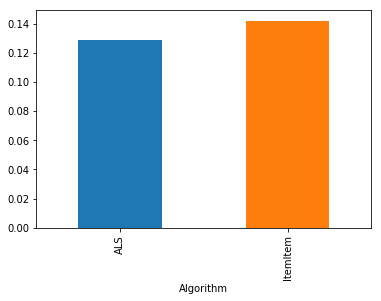

In [17]:
results.groupby('Algorithm').rND.mean().plot.bar()


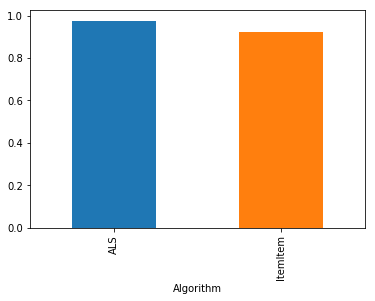

In [16]:
results.groupby('Algorithm').div.mean().plot.bar()